# Simulate Thompson Subsampling

Thompson sampling approach requires updating posteriors for each iteration, however, in each iteration we only know one new label and that may be supply much information for updating. So instead of updating all posteriors we uniformly random sample some entities and relations to update. 

We experiments on how subsampling affects the ROC_AUC_SCORE, cumulative gain as well as running time.

Evaluation metrics:

(1)ROC_AUC_SCORE: calculated between true labels and predictions for each iterations  
(2)Cumulative gain: for each iteration, if the maximum prediction corresponding with the valid labels gain 1, otherwise 0. Show cumulative gain for all iterations.
(3)running time: average running time for each iteration

We chose repeated labelling and Thompson Sampling for 5,000 iterations, and used [NATIONS](https://github.com/dongwookim-ml/kg-data) dataset as an example, there are totally 2,024 valid triples, 14 entities, 56 relations.

From the obvious experiments (notebook exper1 and exper2), we observed when the number of entities and relations are small, the performance is not good. One thought is if we increase the subsampling size when we get more labels, what will happen?

Then we design the comparison experiments:

Experiment1: subn_ent: 2, subn_rel: 2, not change subsampling size

Experiment2: when obsn_labels < 1,000: subn_ent: 2, subn_rel: 2
             otherwise: subn_ent: 10, subn_rel: 10  
             
              (during 5,000 iterations, TS totally get around 1,400 labels)
              
Experiment3: subn_ent: 10, subn_rel: 10, not change subsampling size


In [1]:
# direct to parent folder
import sys
sys.path.append("../acton")

from acton.database import GraphReader, GraphDatabase
from acton.predictors import TensorPredictor
from acton.recommenders import ThompsonSamplingRecommender
from acton.labellers import GraphDatabaseLabeller
import acton.acton
import tempfile
import astropy.io.ascii as io_ascii
import os.path
import numpy
import logging
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logging.basicConfig(level = logging.DEBUG)

_path = 'kg-data/nation/triples.txt'
output_path = 'acton.proto'
outfile_path = "ts_subsampling_exper3/"
n_dim = 10
TS= 0.0
RANDOM = 1.0

In [ ]:
# with GraphReader(_path, n_dim) as reader:
    n_relations = reader.n_relations
    n_entities = reader.n_entities
    totoal_size = n_relations * n_entities * n_entities
    ids = numpy.arange(totoal_size)
    
    N_EPOCHS = 5000
    repeated_labelling = True

    results = defaultdict(list)
    
    subn_ent = [2]
    subn_rel = [2]
    inc_sub = True
    
    # rtrs: repeated train ROC-AUC-SCORE
    # rtes: repeated test ROC-AUC-SCORE
    # rg: repeated cumulative gain
    
    for i in range(len(subn_ent)):
        subn_entities = subn_ent[i]
        subn_relations = subn_rel[i]
    
        label = '_e' + str(subn_entities) + '_r' + str(subn_relations)
        logging.debug(label)
        
        results['TS_rtrs' + label], results['TS_rtes' + label],\
        results['TS_rg' + label], results['time' + label] =  \
            acton.acton.simulate_active_learning(
                ids, reader, {}, output_path,
                n_epochs=N_EPOCHS,
                recommender='ThompsonSamplingRecommender',
                predictor='TensorPredictor',
                labeller='GraphDatabaseLabeller',
                diversity=TS,
                repeated_labelling=repeated_labelling,
                inc_sub = inc_sub,
                subn_entities = int(subn_entities),
                subn_relations = int(subn_relations)
        )
    
    with open(outfile_path + 'outfile_inc', 'wb') as fp:
        pickle.dump(results,fp)  

In [9]:
with open (outfile_path + 'outfile_inc', 'rb') as fp:
    results_inc = pickle.load(fp)
    
with open ('ts_subsampling_exper2/outfile', 'rb') as fp:
    results = pickle.load(fp)

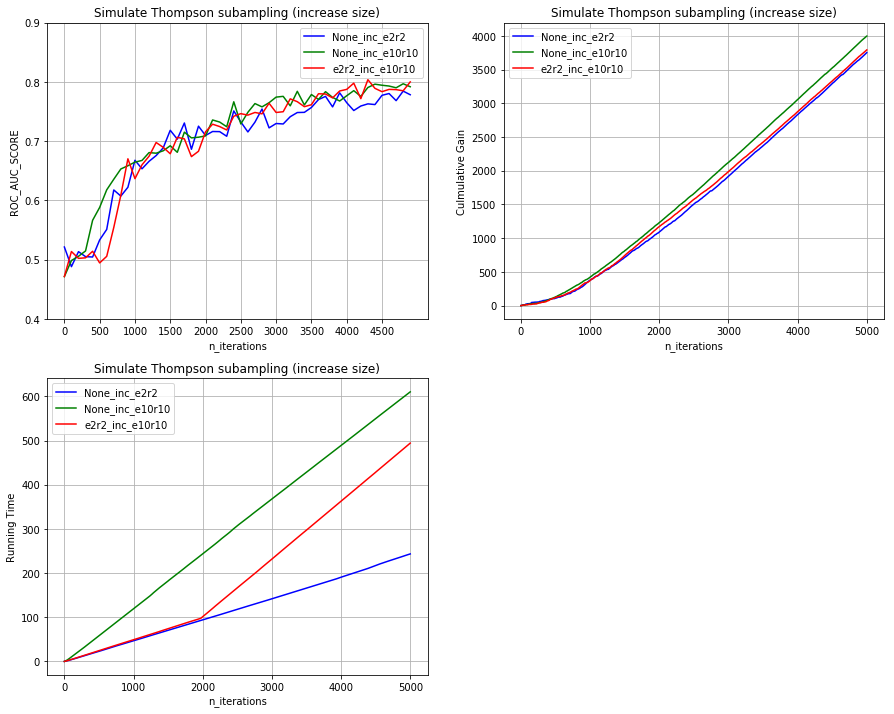

In [19]:
# with open ('outfile_sub50', 'rb') as fp:
#    results = pickle.load(fp)

plt.figure(figsize= (15,12))

color = ['b', 'g', 'r', 'c', 'm', 'y']
    
# rtrs: repeated train ROC-AUC-SCORE
# rtes: repeated test ROC-AUC-SCORE
# rg: repeated cumulative gain

plt.subplot(221)

plt.plot(results['TS_rtrs_e2_r2'][::100], label = 'None_inc_e2r2', color = color[0])
plt.plot(results['TS_rtrs_e10_r10'][::100], label = 'None_inc_e10r10', color = color[1])
plt.plot(results_inc['TS_rtrs_e2_r2'][::100], label = 'e2r2_inc_e10r10', color = color[2])

plt.ylabel('ROC_AUC_SCORE')
plt.xlabel('n_iterations')
plt.xticks(numpy.arange(50, step = 5), numpy.arange(5000)[::500])
plt.ylim(0.4,0.9)
plt.title('Simulate Thompson subampling (increase size)')
plt.grid(True)
plt.legend()

plt.subplot(222)

plt.plot(numpy.cumsum(results['TS_rg_e2_r2']), label = 'None_inc_e2r2', color = color[0])
plt.plot(numpy.cumsum(results['TS_rg_e10_r10']), label = 'None_inc_e10r10', color = color[1])
plt.plot(numpy.cumsum(results_inc['TS_rg_e2_r2']), label = 'e2r2_inc_e10r10', color = color[2])

plt.ylabel('Culmulative Gain')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('Simulate Thompson subampling (increase size)')
plt.grid(True)
plt.legend()

plt.subplot(223)

plt.plot(numpy.cumsum(results['time_e2_r2']), label = 'None_inc_e2r2', color = color[0])
plt.plot(numpy.cumsum(results['time_e10_r10']), label = 'None_inc_e10r10', color = color[1])
plt.plot(numpy.cumsum(results_inc['time_e2_r2']), label = 'e2r2_inc_e10r10', color = color[2])

plt.ylabel('Running Time')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('Simulate Thompson subampling (increase size)')
plt.grid(True)
plt.legend()


### plot gain vs running time

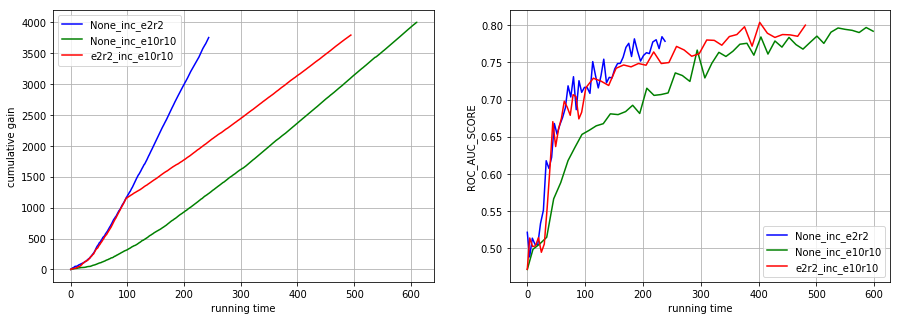

In [24]:
plt.figure(figsize= (15,5))


# rtrs: repeated train ROC-AUC-SCORE
# rtes: repeated test ROC-AUC-SCORE
# rg: repeated cumulative gain

plt.subplot(121)

plt.plot(numpy.cumsum(results['time_e2_r2']), 
         numpy.cumsum(results['TS_rg_e2_r2']), label='None_inc_e2r2', color = color[0])
plt.plot(numpy.cumsum(results['time_e10_r10']), 
         numpy.cumsum(results['TS_rg_e10_r10']), label='None_inc_e10r10', color = color[1])
plt.plot(numpy.cumsum(results_inc['time_e2_r2']), 
         numpy.cumsum(results_inc['TS_rg_e2_r2']), label='e2r2_inc_e10r10', color = color[2])
    
plt.xlabel("running time")
plt.ylabel("cumulative gain")
plt.legend()
plt.grid(True)

plt.subplot(122)
plt.plot(numpy.cumsum(results['time_e2_r2'])[::100], 
         results['TS_rtrs_e2_r2'][::100], label='None_inc_e2r2', color = color[0])
plt.plot(numpy.cumsum(results['time_e10_r10'])[::100], 
         results['TS_rtrs_e10_r10'][::100], label='None_inc_e10r10', color = color[1])
plt.plot(numpy.cumsum(results_inc['time_e2_r2'])[::100], 
         results_inc['TS_rtrs_e2_r2'][::100], label='e2r2_inc_e10r10', color = color[2])
plt.xlabel("running time")
plt.ylabel("ROC_AUC_SCORE")
plt.legend()
plt.grid(True)
